In [1]:
!pip install mediapipe opencv-python
!pip install mediapipe


In [2]:
import cv2
import time
import math as m
import mediapipe as mp
import numpy as np


In [3]:
#initialize mediapipe selfie segmentation class
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_holistic = mp.solutions.holistic

In [4]:
#offset  distance between two points : hip points, the eyes or shoulder.
def findDistance(x1, y1, x2, y2):
    dist = m.sqrt((x2-x1)**2+(y2-y1)**2)
    return dist

In [5]:
# Calculate angle.
def findAngle(x1, y1, x2, y2):
    theta = m.acos((y2 -y1)*(-y1) / (m.sqrt((x2 - x1)**2 + (y2 - y1)**2) * y1))
    degree = int(180/m.pi)*theta
    return degree

In [6]:
# Initilize frame counters.
good_frames = 0
bad_frames = 0

# Font type.
font = cv2.FONT_HERSHEY_SIMPLEX

# Colors.
blue = (255, 127, 0)
red = (50, 50, 255)
green = (127, 255, 0)
dark_blue = (127, 20, 0)
light_green = (127, 233, 100)
yellow = (0, 255, 255)
pink = (255, 0, 255)

In [11]:
#!pip install python-telegram-bot
#!pip install plyer

In [12]:
import telegram

def sendWarning():
    bot = telegram.Bot(token='7120247992:AAG6x2e7ANDQCAGCaaeR3dR1mWadgsncRLA')
    chat_id = '6336666746'  # Replace with your chat ID or channel/group ID
    bot.send_message(chat_id=chat_id, text='Alert: Bad posture detected! Take a break and correct your posture.')

In [13]:
from plyer import notification

def sendWarning():
    notification.notify(
        title='Posture Alert',
        message='Bad posture detected! Take a break and correct your posture.',
        app_name='Posture Corrector',
        timeout=10  # Display the notification for 10 seconds
    )

In [14]:

    # For webcam input replace file name with 0.
    file_name = 0
    cap = cv2.VideoCapture(file_name)
    notification_sent = False
    good_time_counter = 0
    
    # retrives Meta data about video stream.
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    frame_size = (width, height)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')

    # Video writer.
    video_output = cv2.VideoWriter('output.mp4', fourcc, fps, frame_size)
    

    while cap.isOpened():
        # Capture frames.
        success, image = cap.read()
        if not success:
            print("Null.Frames")
            break
        # Get fps.
        fps = cap.get(cv2.CAP_PROP_FPS)
        # Get height and width.
        h, w = image.shape[:2]

        # Convert the BGR image to RGB.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Process the image to detect keypoints.
        keypoints = pose.process(image)

        # Convert the image back to BGR.
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Use lm and lmPose as representative of the following methods.
        lm = keypoints.pose_landmarks
        lmPose = mp_pose.PoseLandmark

        # Acquire the landmark coordinates.
        # Once aligned properly, left or right should not be a concern.      
        # Left shoulder.
        l_shldr_x = int(lm.landmark[lmPose.LEFT_SHOULDER].x * w)
        l_shldr_y = int(lm.landmark[lmPose.LEFT_SHOULDER].y * h)
        # Right shoulder
        r_shldr_x = int(lm.landmark[lmPose.RIGHT_SHOULDER].x * w)
        r_shldr_y = int(lm.landmark[lmPose.RIGHT_SHOULDER].y * h)
        # Left ear.
        l_ear_x = int(lm.landmark[lmPose.LEFT_EAR].x * w)
        l_ear_y = int(lm.landmark[lmPose.LEFT_EAR].y * h)
        # Left hip.
        l_hip_x = int(lm.landmark[lmPose.LEFT_HIP].x * w)
        l_hip_y = int(lm.landmark[lmPose.LEFT_HIP].y * h)

        # Calculate distance between left shoulder and right shoulder points.
        offset = findDistance(l_shldr_x, l_shldr_y, r_shldr_x, r_shldr_y)

        # Assist to align the camera to point at the side view of the person.
        # w-150 text positioning
        # Offset threshold 30 is based on results obtained from analysis over 100 samples.
        if offset < 100:
            cv2.putText(image, str(int(offset)) + ' Aligned', (w - 150, 30), font, 0.9, green, 2)
        else:
            cv2.putText(image, str(int(offset)) + ' Not Aligned', (w - 150, 30), font, 0.9, red, 2)

        # Calculate angles.
        neck_inclination = findAngle(l_shldr_x, l_shldr_y, l_ear_x, l_ear_y)
        torso_inclination = findAngle(l_hip_x, l_hip_y, l_shldr_x, l_shldr_y)

        # Draw landmarks.
        cv2.circle(image, (l_shldr_x, l_shldr_y), 7, yellow, -1)
        cv2.circle(image, (l_ear_x, l_ear_y), 7, yellow, -1)

        # Let's take y - coordinate of P3 100px above x1,  for display elegance.
        # Although we are taking y = 0 while calculating angle between P1,P2,P3.
        cv2.circle(image, (l_shldr_x, l_shldr_y - 100), 7, yellow, -1)
        cv2.circle(image, (r_shldr_x, r_shldr_y), 7, pink, -1)
        cv2.circle(image, (l_hip_x, l_hip_y), 7, yellow, -1)

        # Similarly, here we are taking y - coordinate 100px above x1. Note that
        # you can take any value for y, not necessarily 100 or 200 pixels.
        cv2.circle(image, (l_hip_x, l_hip_y - 100), 7, yellow, -1)

        # Put text, Posture and angle inclination.
        # Text string for display.
        angle_text_string = 'Neck : ' + str(int(neck_inclination)) + '  Torso : ' + str(int(torso_inclination))

        # Determine whether good posture or bad posture.
        # The threshold angles have been set based on intuition.
        if neck_inclination < 40 and torso_inclination < 10:
            bad_frames = 0
            good_frames += 1
            
            cv2.putText(image, angle_text_string, (10, 30), font, 0.9, light_green, 2)
            cv2.putText(image, str(int(neck_inclination)), (l_shldr_x + 10, l_shldr_y), font, 0.9, light_green, 2)
            cv2.putText(image, str(int(torso_inclination)), (l_hip_x + 10, l_hip_y), font, 0.9, light_green, 2)

            # Join landmarks.
            cv2.line(image, (l_shldr_x, l_shldr_y), (l_ear_x, l_ear_y), green, 4)
            cv2.line(image, (l_shldr_x, l_shldr_y), (l_shldr_x, l_shldr_y - 100), green, 4)
            cv2.line(image, (l_hip_x, l_hip_y), (l_shldr_x, l_shldr_y), green, 4)
            cv2.line(image, (l_hip_x, l_hip_y), (l_hip_x, l_hip_y - 100), green, 4)

        else:
            good_frames = 0
            bad_frames += 1

            cv2.putText(image, angle_text_string, (10, 30), font, 0.9, red, 2)
            cv2.putText(image, str(int(neck_inclination)), (l_shldr_x + 10, l_shldr_y), font, 0.9, red, 2)
            cv2.putText(image, str(int(torso_inclination)), (l_hip_x + 10, l_hip_y), font, 0.9, red, 2)

            # Join landmarks.
            cv2.line(image, (l_shldr_x, l_shldr_y), (l_ear_x, l_ear_y), red, 4)
            cv2.line(image, (l_shldr_x, l_shldr_y), (l_shldr_x, l_shldr_y - 100), red, 4)
            cv2.line(image, (l_hip_x, l_hip_y), (l_shldr_x, l_shldr_y), red, 4)
            cv2.line(image, (l_hip_x, l_hip_y), (l_hip_x, l_hip_y - 100), red, 4)
        
        # Calculate the time of remaining in a particular posture.
        good_time = (1 / fps) * good_frames
        bad_time =  (1 / fps) * bad_frames
        # Pose time.
        if good_time > 0:
            time_string_good = 'Good Posture Time : ' + str(round(good_time, 1)) + 's'
            cv2.putText(image, time_string_good, (10, h - 20), font, 0.9, green, 2)
            good_time_counter += 1
            if good_time_counter > 10:  # Reset the notification flag after 10 good frames
                notification_sent = False
                good_time_counter = 0
        else:
            time_string_bad = 'Bad Posture Time : ' + str(round(bad_time, 1)) + 's'
            cv2.putText(image, time_string_bad, (10, h - 20), font, 0.9, red, 2)
            good_time_counter = 0

        # If you stay in bad posture for more than 5 seconds, send an alert.
        if bad_time > 5 and not notification_sent:
            sendWarning()
            notification_sent = True
        

        # Display.
        cv2.imshow('MediaPipe Pose', image)
        if cv2.waitKey(5) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


In [8]:
import time

In [15]:
#application of segmentation mask from configurable API
#to differentiate person from background
mp_pose1 = mp.solutions.pose
pose1 = mp_pose1.Pose(
    static_image_mode=False,  # Set to True if processing static images
    model_complexity=1,  # 0, 1 or 2. Increasing the value increases accuracy but also inference time
    enable_segmentation=False,  # Set to True if you want to generate segmentation masks
    min_detection_confidence=0.5,  # Minimum confidence value for detection to be considered successful
    min_tracking_confidence=0.5  # Minimum confidence value for landmarks to be considered tracked
)

In [16]:
keypoints = pose1.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [17]:
# Get the segmentation mask
segmentation_mask = keypoints.segmentation_mask

Recommendations:


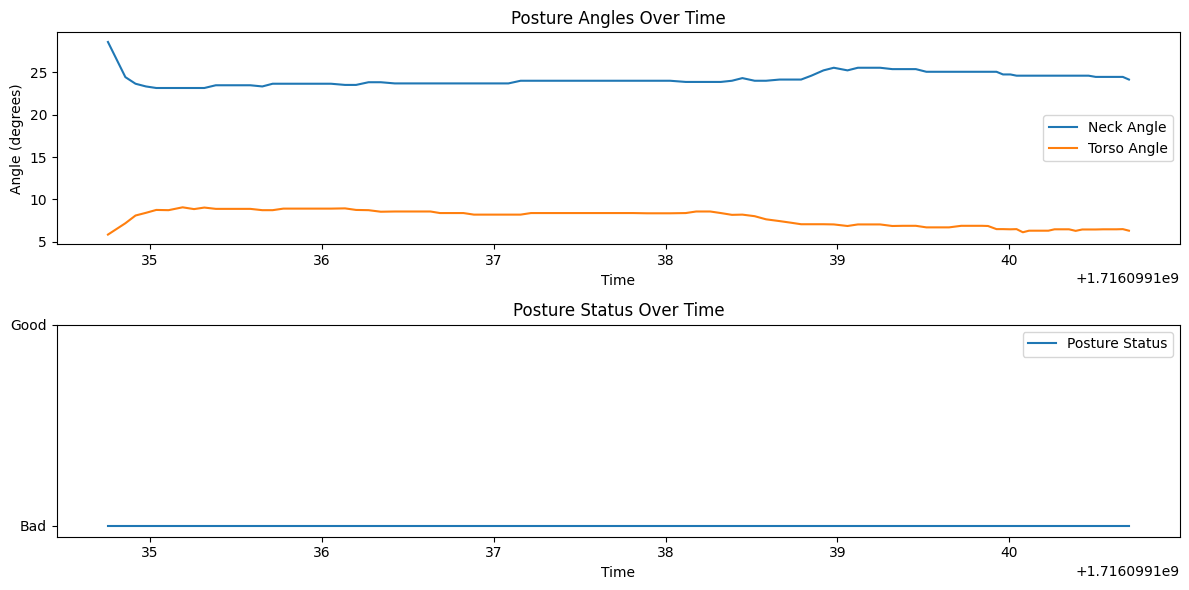

In [22]:
 # For webcam input replace file name with 0.
file_name = 0
cap = cv2.VideoCapture(file_name)
notification_sent = False
good_time_counter = 0
# Meta.
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_size = (width, height)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
posture_data = []
    # Video writer.
video_output = cv2.VideoWriter('output.mp4', fourcc, fps, frame_size)

while cap.isOpened():
    # Capture frames.
    success, image = cap.read()
    if not success:
        print("Null.Frames")
        break
        # Get fps.
    fps = cap.get(cv2.CAP_PROP_FPS)
        # Get height and width.
    h, w = image.shape[:2]
    # Inside the video capture loop
    posture_entry = {
        'timestamp': time.time(),
        'neck_angle': neck_inclination,
        'torso_angle': torso_inclination,
        'status': 'Good' if neck_inclination < 40 and torso_inclination < 10 else 'Bad'
    }
    posture_data.append(posture_entry)
        # Convert the BGR image to RGB.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        # Process the image.
    keypoints = pose1.process(image)

        # Convert the image back to BGR.
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Use lm and lmPose as representative of the following methods.
    lm = keypoints.pose_landmarks
    lmPose = mp_pose1.PoseLandmark

        # Acquire the landmark coordinates.
        # Once aligned properly, left or right should not be a concern.      
        # Left shoulder.
    l_shldr_x = int(lm.landmark[lmPose.LEFT_SHOULDER].x * w)
    l_shldr_y = int(lm.landmark[lmPose.LEFT_SHOULDER].y * h)
        # Right shoulder
    r_shldr_x = int(lm.landmark[lmPose.RIGHT_SHOULDER].x * w)
    r_shldr_y = int(lm.landmark[lmPose.RIGHT_SHOULDER].y * h)
        # Left ear.
    l_ear_x = int(lm.landmark[lmPose.LEFT_EAR].x * w)
    l_ear_y = int(lm.landmark[lmPose.LEFT_EAR].y * h)
        # Left hip.
    l_hip_x = int(lm.landmark[lmPose.LEFT_HIP].x * w)
    l_hip_y = int(lm.landmark[lmPose.LEFT_HIP].y * h)

        # Calculate distance between left shoulder and right shoulder points.
    offset = findDistance(l_shldr_x, l_shldr_y, r_shldr_x, r_shldr_y)

        # Assist to align the camera to point at the side view of the person.
        # Offset threshold 30 is based on results obtained from analysis over 100 samples.
    if offset < 100:
        cv2.putText(image, str(int(offset)) + ' Aligned', (w - 150, 30), font, 0.9, green, 2)
    else:
        cv2.putText(image, str(int(offset)) + ' Not Aligned', (w - 150, 30), font, 0.9, red, 2)

        # Calculate angles.
    neck_inclination = findAngle(l_shldr_x, l_shldr_y, l_ear_x, l_ear_y)
    torso_inclination = findAngle(l_hip_x, l_hip_y, l_shldr_x, l_shldr_y)

        # Draw landmarks.
    cv2.circle(image, (l_shldr_x, l_shldr_y), 7, yellow, -1)
    cv2.circle(image, (l_ear_x, l_ear_y), 7, yellow, -1)

        # Let's take y - coordinate of P3 100px above x1,  for display elegance.
        # Although we are taking y = 0 while calculating angle between P1,P2,P3.
    cv2.circle(image, (l_shldr_x, l_shldr_y - 100), 7, yellow, -1)
    cv2.circle(image, (r_shldr_x, r_shldr_y), 7, pink, -1)
    cv2.circle(image, (l_hip_x, l_hip_y), 7, yellow, -1)

        # Similarly, here we are taking y - coordinate 100px above x1. Note that
        # you can take any value for y, not necessarily 100 or 200 pixels.
    cv2.circle(image, (l_hip_x, l_hip_y - 100), 7, yellow, -1)

        # Put text, Posture and angle inclination.
        # Text string for display.
    angle_text_string = 'Neck : ' + str(int(neck_inclination)) + '  Torso : ' + str(int(torso_inclination))

        # Determine whether good posture or bad posture.
        # The threshold angles have been set based on intuition.
    if neck_inclination < 40 and torso_inclination < 10:
        bad_frames = 0
        good_frames += 1
            
        cv2.putText(image, angle_text_string, (10, 30), font, 0.9, light_green, 2)
        cv2.putText(image, str(int(neck_inclination)), (l_shldr_x + 10, l_shldr_y), font, 0.9, light_green, 2)
        cv2.putText(image, str(int(torso_inclination)), (l_hip_x + 10, l_hip_y), font, 0.9, light_green, 2)

            # Join landmarks.
        cv2.line(image, (l_shldr_x, l_shldr_y), (l_ear_x, l_ear_y), green, 4)
        cv2.line(image, (l_shldr_x, l_shldr_y), (l_shldr_x, l_shldr_y - 100), green, 4)
        cv2.line(image, (l_hip_x, l_hip_y), (l_shldr_x, l_shldr_y), green, 4)
        cv2.line(image, (l_hip_x, l_hip_y), (l_hip_x, l_hip_y - 100), green, 4)

    else:
        good_frames = 0
        bad_frames += 1

        cv2.putText(image, angle_text_string, (10, 30), font, 0.9, red, 2)
        cv2.putText(image, str(int(neck_inclination)), (l_shldr_x + 10, l_shldr_y), font, 0.9, red, 2)
        cv2.putText(image, str(int(torso_inclination)), (l_hip_x + 10, l_hip_y), font, 0.9, red, 2)

            # Join landmarks.
        cv2.line(image, (l_shldr_x, l_shldr_y), (l_ear_x, l_ear_y), red, 4)
        cv2.line(image, (l_shldr_x, l_shldr_y), (l_shldr_x, l_shldr_y - 100), red, 4)
        cv2.line(image, (l_hip_x, l_hip_y), (l_shldr_x, l_shldr_y), red, 4)
        cv2.line(image, (l_hip_x, l_hip_y), (l_hip_x, l_hip_y - 100), red, 4)
        
        # Calculate the time of remaining in a particular posture.
    good_time = (1 / fps) * good_frames
    bad_time =  (1 / fps) * bad_frames
        # Pose time.
    if good_time > 0:
        time_string_good = 'Good Posture Time : ' + str(round(good_time, 1)) + 's'
        cv2.putText(image, time_string_good, (10, h - 20), font, 0.9, green, 2)
        good_time_counter += 1
        if good_time_counter > 10:  # Reset the notification flag after 10 good frames
            notification_sent = False
            good_time_counter = 0
    else:
        time_string_bad = 'Bad Posture Time : ' + str(round(bad_time, 1)) + 's'
        cv2.putText(image, time_string_bad, (10, h - 20), font, 0.9, red, 2)
        good_time_counter = 0

        # If you stay in bad posture for more than 5 seconds, send an alert.
    if bad_time > 5 and not notification_sent:
        sendWarning()
        notification_sent = True
        

        # Display.
    cv2.imshow('MediaPipe Pose', image)
    if cv2.waitKey(5) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Calculate posture statistics
posture_stats = calculate_posture_stats(posture_data)

# Provide recommendations
recommendations = provide_recommendations(posture_stats)

# Print recommendations
print("Recommendations:")
for recommendation in recommendations:
    print(f"- {recommendation}")

# Visualize posture data
visualize_posture_data(posture_data)


In [19]:
def calculate_posture_stats(posture_data):
    total_time = 0
    good_time = 0
    bad_time = 0
    avg_neck_angle = 0
    avg_torso_angle = 0
    
    for entry in posture_data:
        total_time += 1
        if entry['status'] == 'Good':
            good_time += 1
            avg_neck_angle += entry['neck_angle']
            avg_torso_angle += entry['torso_angle']
        else:
            bad_time += 1
            
    avg_neck_angle /= good_time if good_time > 0 else 1
    avg_torso_angle /= good_time if good_time > 0 else 1
    
    return {
        'total_time': total_time,
        'good_time': good_time,
        'bad_time': bad_time,
        'avg_neck_angle': avg_neck_angle,
        'avg_torso_angle': avg_torso_angle
    }

In [20]:
import matplotlib.pyplot as plt

def visualize_posture_data(posture_data):
    timestamps = [entry['timestamp'] for entry in posture_data]
    neck_angles = [entry['neck_angle'] for entry in posture_data]
    torso_angles = [entry['torso_angle'] for entry in posture_data]
    posture_status = ['Good' if entry['status'] == 'Good' else 'Bad' for entry in posture_data]

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(timestamps, neck_angles, label='Neck Angle')
    plt.plot(timestamps, torso_angles, label='Torso Angle')
    plt.xlabel('Time')
    plt.ylabel('Angle (degrees)')
    plt.legend()
    plt.title('Posture Angles Over Time')

    plt.subplot(2, 1, 2)
    plt.plot(timestamps, posture_status, label='Posture Status')
    plt.xlabel('Time')
    plt.yticks([0, 1], ['Bad', 'Good'])
    plt.legend()
    plt.title('Posture Status Over Time')

    plt.tight_layout()
    plt.show()

In [21]:
def provide_recommendations(posture_stats):
    recommendations = []
    
    if posture_stats['bad_time'] > 0.3 * posture_stats['total_time']:
        recommendations.append('Take frequent breaks to avoid prolonged bad posture.')
        
    if posture_stats['avg_neck_angle'] > 50:
        recommendations.append('Perform neck stretches and adjust your screen height.')
        
    if posture_stats['avg_torso_angle'] > 20:
        recommendations.append('Adjust your chair height and consider using a lumbar support.')
        
    return recommendations

In [21]:
# #making detection
# cap = cv2.VideoCapture(0)
# ## Setup mediapipe instance
# with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
#     while cap.isOpened():
#         ret, frame = cap.read()
        
#         # Recolor image to RGB
#         image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         image.flags.writeable = False
      
#         # Make detection
#         results = pose.process(image)
    
#         # Recolor back to BGR
#         image.flags.writeable = True
#         image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
#         # Render detections
#         mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
#                                 mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
#                                 mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
#                                  )               
        
#         cv2.imshow('Mediapipe Feed', image)

#         if cv2.waitKey(10) & 0xFF == ord('q'):
#             break

#     cap.release()
#     cv2.destroyAllWindows()